# X to Autosome Ratio

Here I perform a preliminary dosage compensation experiment in testis. This is a very rough preliminary analysis, but I have played with lots of different normalizations and ways of looking at things and the results are consistent. There appears to be attenuated dosage compensation in germ cells. 

In [1]:
# %load ../start.py
# Load useful extensions

# Activate the autoreload extension for easy reloading of external packages
%reload_ext autoreload
%autoreload 2

# Trun on the water mark
%reload_ext watermark
%watermark -u -d -g

# Load ipycache extension
%reload_ext ipycache
from ipycache import CacheMagics
CacheMagics.cachedir = '../cachedir'

# The usual suspects
import os
from itertools import zip_longest
import numpy as np
import pandas as pd

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('white')
sns.set_context('notebook')
sns.mpl.rc("figure", figsize=(10, 10))

# Turn off scientific notation
np.set_printoptions(precision=5, suppress=True)


last updated: 2017-11-22 
Git hash: 3fc4445cb5b9f3089960085945b76a98ae924561


In [2]:
# functions
def grouper(iterable, n):
    args = [iter(iterable)] * n
    return zip_longest(*args)

In [3]:
# Get count matrix
testis = pd.read_csv('../../output/single_cell_matrix_testis.tsv', sep='\t', index_col=0)
te = testis.drop('gene_symbol', axis=1).T

print(te.shape)
te.head()

(483, 17473)


,FBgn0031081,FBgn0052826,FBgn0031085,FBgn0062565,FBgn0031088,FBgn0041626,FBgn0040784,FBgn0031086,FBgn0031082,FBgn0031080,...,FBgn0016926,FBgn0031299,FBgn0003310,FBgn0031295,FBgn0031273,FBgn0011244,FBgn0031275,FBgn0031276,FBgn0040725,FBgn0031277
AAACCTGGTTCATGGT-1,0,0,2,0,0,0,3,0,0,0,...,0,0,0,17,0,2,0,0,0,0
AAACGGGAGACTGGGT-1,0,0,0,0,0,0,0,0,0,1,...,9,3,4,0,0,0,0,0,0,0
AAACGGGGTGTTAAGA-1,0,0,0,0,0,0,0,0,0,1,...,5,0,2,0,2,0,0,0,0,0
AAAGATGAGTATCGAA-1,0,0,0,0,0,0,0,0,0,1,...,3,0,2,0,0,0,0,0,0,0
AAAGCAAGTCTAGGTT-1,0,0,0,0,0,0,24,0,0,0,...,6,0,7,1,1,0,0,0,0,0


In [4]:
# Get clusters information
clusters = pd.read_csv('../../output/testis_clusters.tsv', sep='\t', header=None)

clusters.columns = ['cell', 'cluster']

clusters['cell_id'] = clusters.cell.apply(lambda x: '{}-1'.format(x))
clusters.drop('cell', axis=1, inplace=True)
print(clusters.shape)
clusters.head()

(477, 2)


,cluster,cell_id
0,4,AAACCTGGTTCATGGT-1
1,6,AAACGGGAGACTGGGT-1
2,1,AAACGGGGTGTTAAGA-1
3,6,AAAGATGAGTATCGAA-1
4,3,AAAGCAAGTCTAGGTT-1


In [5]:
# Make look up tables
fbgn2symbol = testis['gene_symbol'].to_dict()
symbol2fbgn = {}
for k, v in fbgn2symbol.items():
    symbol2fbgn[v] = k

In [6]:
# Genes need to be expressed in 1/3 of samples.
expressed = (te > 0).sum() > te.shape[0] / 3

In [7]:
# make fbgn2chrom
REF = os.environ['REFERENCES_DIR']
CHROMS = ['chrX', 'chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4']
BRIAN = ['dj', 'ocn', 'CG10920', 'CG12681', 'CG1314']

genes = []
with open(os.path.join(REF, 'dmel/r6-11/gtf/dmel_r6-11.gtf')) as fh:
    for row in fh:
        rows = row.strip().split()
        
        if len(rows) == 0:
            continue
            
        if rows[2] == 'gene':
            genes.append((rows[0], rows[9].replace('"', '').replace(';', '')))

fbgn2chrom = pd.DataFrame(genes, columns=['chrom', 'FBgn'])
fbgn2chrom.set_index('FBgn', inplace=True)
fbgn2chrom = fbgn2chrom[fbgn2chrom['chrom'].isin(CHROMS)]

In [8]:
# germ cells vasa positive
germ = te[te[symbol2fbgn['vas']] > 0].T

# The germ cells belog to cluster 3
cluster3 = te[te.index.isin(clusters[clusters.cluster == 3].index)].T

# Cluster 4 also looks germ cell like, erika thinks they are older spermatocytes
cluster4 = te[te.index.isin(clusters[clusters.cluster == 4].index)].T

# somatic cells
soma = te[te[symbol2fbgn['dsx']] > 0].T



In [9]:
# functions
def xtoa(df):
    # normalize
    def libnorm(df):
        df2 = df[expressed].copy()
        return np.log2(df2 / df2.sum() * 10**4 + 1)

    df_rpm = libnorm(df)

    # Aggregate across samples
    def agg_samples(df, aggfunc=np.median):
        med = df.apply(aggfunc, axis=1).to_frame()
        merged = med.join(fbgn2chrom, how='inner').set_index('chrom', append=True)
        merged.sort_index(inplace=True)
        merged.columns = ['med_rpm']
        return merged

    df_rpm_smed = agg_samples(df_rpm, aggfunc=np.median)

    # Center samples using X chrom
    def median_center(df):
        return df - df.loc[(slice(None), 'chrX'), :].median()

    return median_center(df_rpm_smed)

def plot_xtoa(df, ax, name):
    sns.boxplot(df.index.get_level_values(-1), 
                df.med_rpm, notch=True, 
                ax=ax, order=CHROMS,  fliersize=0)
    ax.set_title(name)
    ax.set_ylim(None, 3)
    ax.axhline(0, ls=':')
    ax.set_ylabel('Log 2 Normalized Read Per Million\n(chrX Median Centered)')

In [10]:
germ = te[te[symbol2fbgn['vas']] > 0].T
soma = te[te[symbol2fbgn['dsx']] > 0].T

In [11]:
cls = [
    ('Germ Cells (n={})'.format(germ.shape[1]), xtoa(germ)),
    ('Somatic Cells (n={})'.format(soma.shape[1]), xtoa(soma))
]
for i, dd in clusters.groupby('cluster'):
    cells = dd.cell_id.unique().tolist()
    cls.append(('Cluster {} (n={})'.format(i, dd.shape[0]), xtoa(te[te.index.isin(cells)].T)))

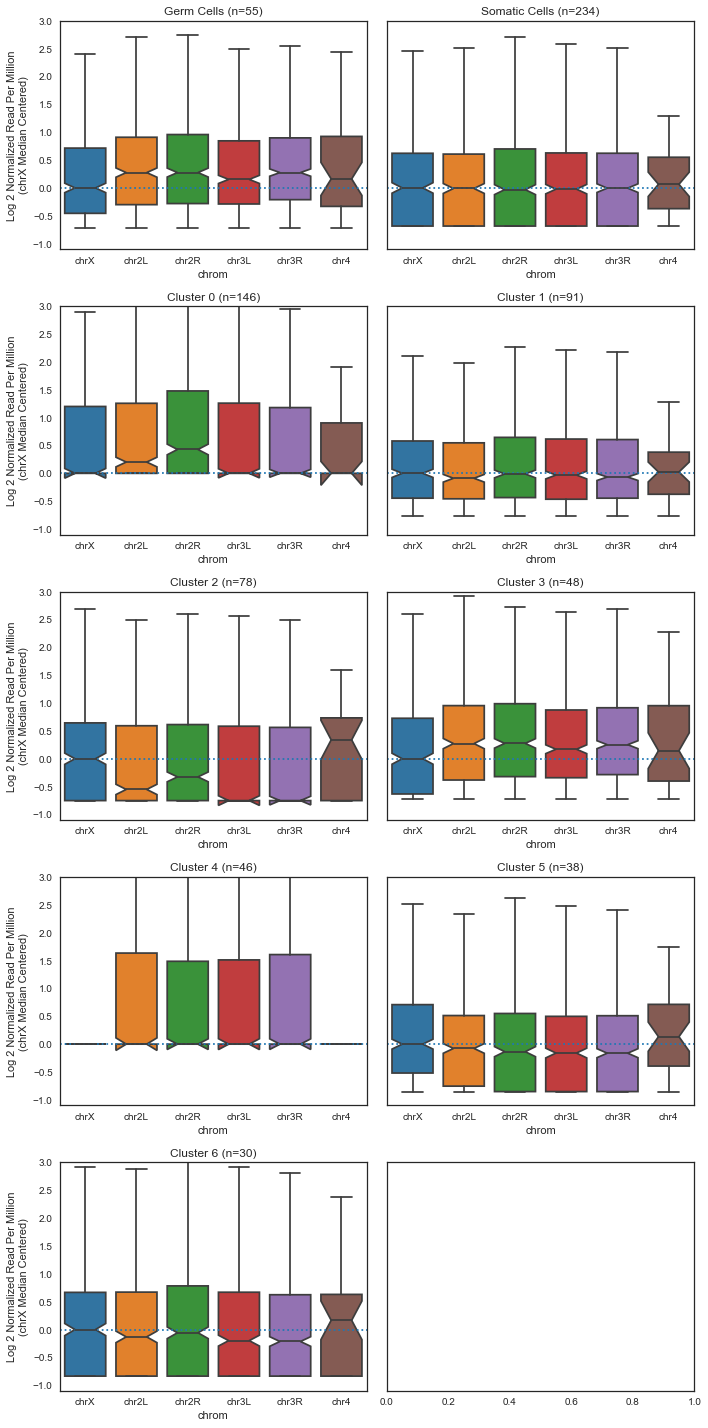

In [12]:
# Boxplots
fig, axes = plt.subplots(5, 2, figsize=plt.figaspect(2)*2, sharey=True)
for (name, df), ax in zip(cls, axes.flatten()):
    plot_xtoa(df, ax, name)

for ax in axes[:, 1]:
    ax.set_ylabel('')
plt.tight_layout()

In [13]:
te.head()

,FBgn0031081,FBgn0052826,FBgn0031085,FBgn0062565,FBgn0031088,FBgn0041626,FBgn0040784,FBgn0031086,FBgn0031082,FBgn0031080,...,FBgn0016926,FBgn0031299,FBgn0003310,FBgn0031295,FBgn0031273,FBgn0011244,FBgn0031275,FBgn0031276,FBgn0040725,FBgn0031277
AAACCTGGTTCATGGT-1,0,0,2,0,0,0,3,0,0,0,...,0,0,0,17,0,2,0,0,0,0
AAACGGGAGACTGGGT-1,0,0,0,0,0,0,0,0,0,1,...,9,3,4,0,0,0,0,0,0,0
AAACGGGGTGTTAAGA-1,0,0,0,0,0,0,0,0,0,1,...,5,0,2,0,2,0,0,0,0,0
AAAGATGAGTATCGAA-1,0,0,0,0,0,0,0,0,0,1,...,3,0,2,0,0,0,0,0,0,0
AAAGCAAGTCTAGGTT-1,0,0,0,0,0,0,24,0,0,0,...,6,0,7,1,1,0,0,0,0,0


In [14]:
merged = clusters.set_index('cell_id').join(te)

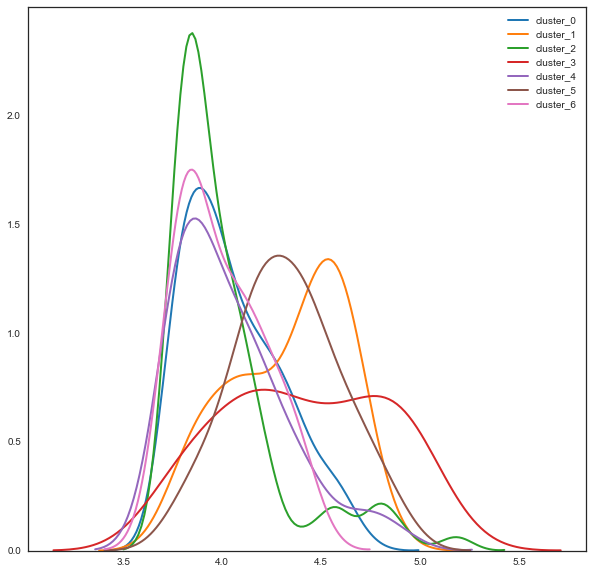

In [15]:
for clus, df in merged.groupby('cluster'):
    sns.distplot(np.log10(df.drop('cluster', axis=1).T.sum()+1), 
                 label='cluster_{}'.format(clus), 
                 hist=False, 
                 kde_kws={'lw': 2})

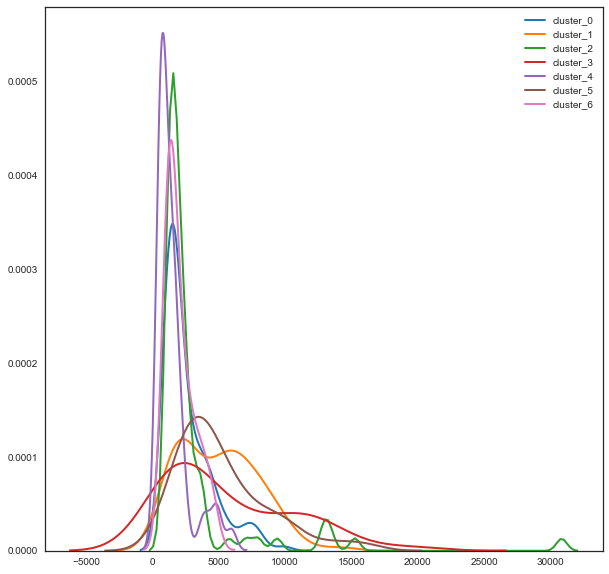

In [16]:
for clus, df in merged.groupby('cluster'):
    ddf = df.drop('cluster', axis=1).T
    mddf = ddf.join(fbgn2chrom)
    mddf = mddf[mddf.chrom == 'chrX'].drop('chrom', axis=1)
    pddf = mddf.sum()
    sns.distplot(pddf, label='cluster_{}'.format(clus), 
                 hist=False,
                 kde_kws={'lw': 2})

In [17]:
merged.head()

,cluster,FBgn0031081,FBgn0052826,FBgn0031085,FBgn0062565,FBgn0031088,FBgn0041626,FBgn0040784,FBgn0031086,FBgn0031082,...,FBgn0016926,FBgn0031299,FBgn0003310,FBgn0031295,FBgn0031273,FBgn0011244,FBgn0031275,FBgn0031276,FBgn0040725,FBgn0031277
cell_id,,,,,,,,,,,,,,,,,,,,,
AAACCTGGTTCATGGT-1,4,0,0,2,0,0,0,3,0,0,...,0,0,0,17,0,2,0,0,0,0
AAACGGGAGACTGGGT-1,6,0,0,0,0,0,0,0,0,0,...,9,3,4,0,0,0,0,0,0,0
AAACGGGGTGTTAAGA-1,1,0,0,0,0,0,0,0,0,0,...,5,0,2,0,2,0,0,0,0,0
AAAGATGAGTATCGAA-1,6,0,0,0,0,0,0,0,0,0,...,3,0,2,0,0,0,0,0,0,0
AAAGCAAGTCTAGGTT-1,3,0,0,0,0,0,0,24,0,0,...,6,0,7,1,1,0,0,0,0,0


['14-3-3epsilon, 14-3-3zeta, ATPsynC, ATPsynD, ATPsynE',
 'ATPsynF, ATPsynO, ATPsynepsilonL, Act5C, Alg-2',
 'Atx2, CCT2, CG10674, CG11138, CG11267',
 'CG11505, CG12384, CG13096, CG13364, CG13540',
 'CG1416, CG14478, CG16817, CG17202, CG17514',
 'CG17650, CG2862, CG31715, CG32971, CG33774',
 'CG34200, CG42857, CG44303, CG44774, CG4502',
 'CG45050, CG5885, CG6770, CG6878, CG6937',
 'CG7518, CG8860, CG9669, CG9705, CG9821',
 'CG9922, CNBP, COX5A, COX6B, COX8',
 'CR43264, Cam, Capr, Cbp20, Cdc37',
 'CtBP, Cyp1, D1, ERp60, FK506-bp1',
 'FKBP59, Fib, Fis1, Fs(2)Ket, Gbeta13F',
 'HP6, His3.3A, His4r, HmgD, Hrb27C',
 'Hrb87F, Hsc70Cb, Hsp26, Hsp27, Hsp83',
 'IscU, Kap-alpha3, Lk6, MED26, MRE16',
 'Mapmodulin, Mnn1, ND-39, ND-ACP, ND-B12',
 'ND-B14.5B, ND-MWFE, Nap1, Nedd8, Nlp',
 'Nop56, Not1, Nph, Pfdn1, Pfdn5',
 'Prosalpha3, Prosalpha5, Prosalpha7, Prosbeta1, Prosbeta4',
 'Prosbeta5, Rad23, Ran, Rho1, RhoGAP71E',
 'Roc1a, RpL10, RpL10Ab, RpL11, RpL12',
 'RpL13, RpL13A, RpL14, RpL15, RpL17',

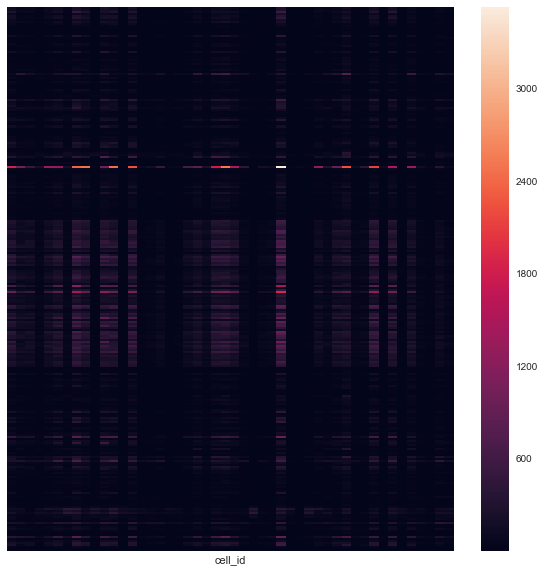

In [18]:
_CLUSTER = 3
clus = merged[merged.cluster == _CLUSTER].T.copy().drop('cluster')
clus = clus[(clus > 0).all(axis=1)].copy()
clus.index = clus.index.map(lambda x: fbgn2symbol[x])

fig, ax = plt.subplots(1, 1)
sns.heatmap(clus.sort_index(), ax=ax, yticklabels=False, xticklabels=False);

[', '.join(x) for x in grouper(clus.sort_index().index, 5)]

['ATPsynCF6L, ATPsynE, ATPsynF, Atg8b, BI-1, CG10252',
 'CG10317, CG10934, CG11106, CG11373, CG11562, CG11663',
 'CG12118, CG12307, CG12470, CG12689, CG12699, CG12853',
 'CG12860, CG12861, CG1324, CG13747, CG13898, CG1394',
 'CG14113, CG1418, CG14488, CG14658, CG14835, CG14995',
 'CG15034, CG15172, CG15177, CG15200, CG15219, CG15461',
 'CG15657, CG15742, CG16739, CG16817, CG17261, CG17376',
 'CG17377, CG17470, CG18449, CG18662, CG1958, CG1988',
 'CG2127, CG2291, CG30039, CG30065, CG30270, CG30324',
 'CG30369, CG30376, CG30430, CG30487, CG31007, CG31050',
 'CG31226, CG3124, CG31360, CG31468, CG31482, CG31639',
 'CG31709, CG31740, CG31788, CG31802, CG31820, CG31909',
 'CG31988, CG32148, CG32192, CG32267, CG32371, CG32450',
 'CG32727, CG33170, CG33189, CG33293, CG33308, CG33340',
 'CG34107, CG34168, CG34241, CG3687, CG42355, CG42393',
 'CG42523, CG42659, CG42688, CG42703, CG42758, CG43059',
 'CG43169, CG43209, CG43222, CG43277, CG43293, CG4375',
 'CG43922, CG43935, CG45490, CG45603, CG460

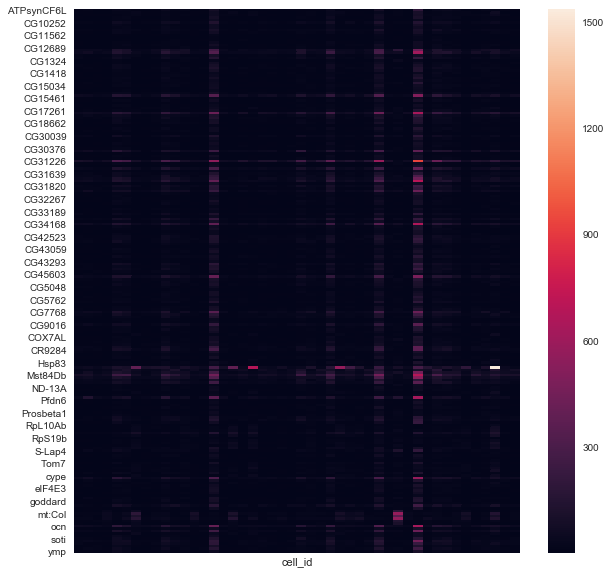

In [19]:
_CLUSTER = 4
clus = merged[merged.cluster == _CLUSTER].T.copy().drop('cluster')
clus = clus[(clus > 0).all(axis=1)].copy()
clus.index = clus.index.map(lambda x: fbgn2symbol[x])

fig, ax = plt.subplots(1, 1)
sns.heatmap(clus.sort_index(), ax=ax, xticklabels=False);

[', '.join(x) for x in grouper(clus.sort_index().index, 6)]